In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =294

ng =18

nref =3

p_refs = (/ 1 , 20 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

ng_refs = (/ 6 , 6 , 6 /) 

data wgt
     &     /1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

klin =6.5e-24

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

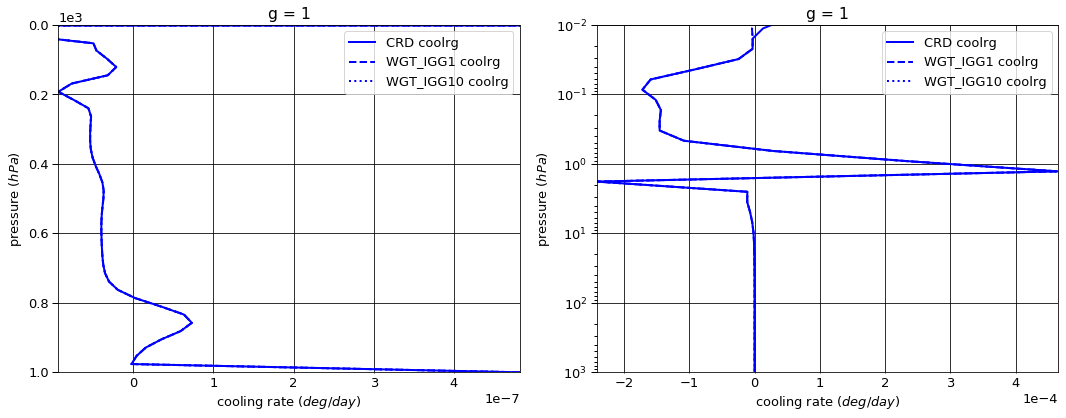

# Figure: cooling rate g-group 2

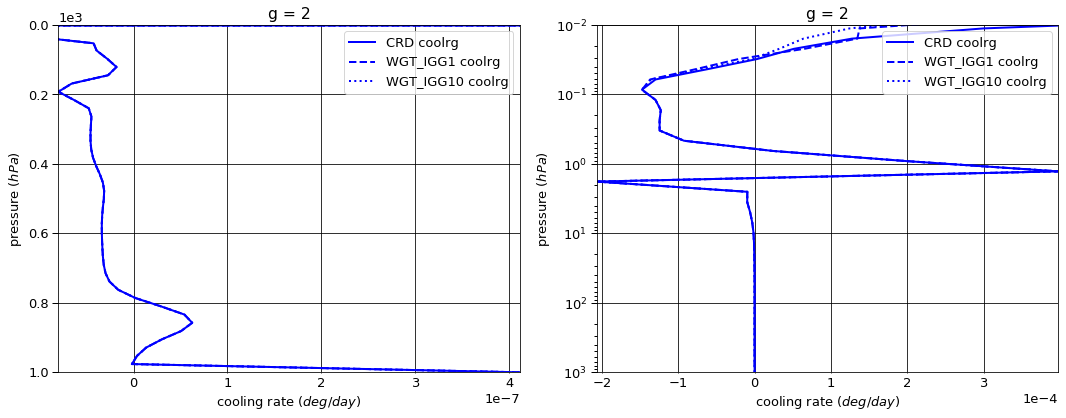

# Figure: cooling rate g-group 3

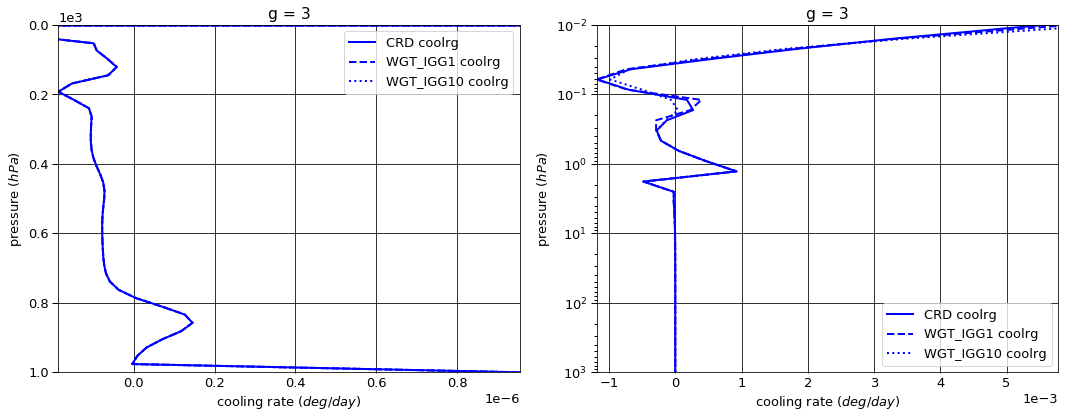

# Figure: cooling rate g-group 4

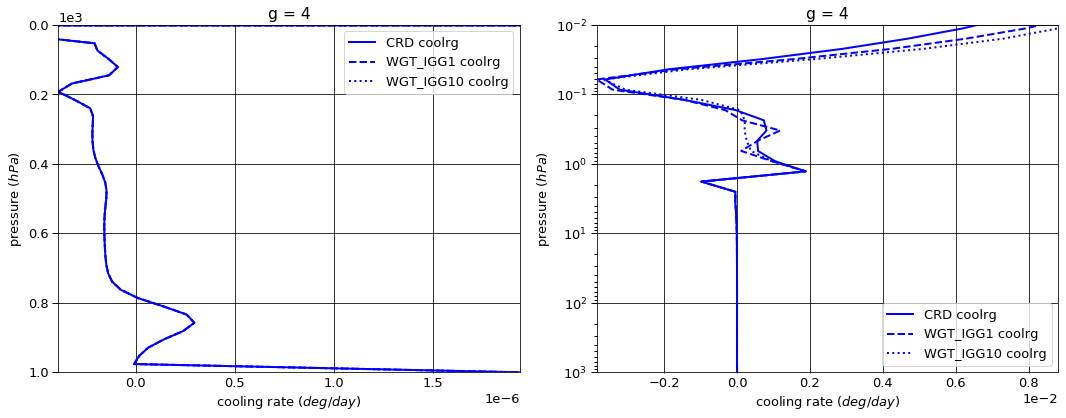

# Figure: cooling rate g-group 5

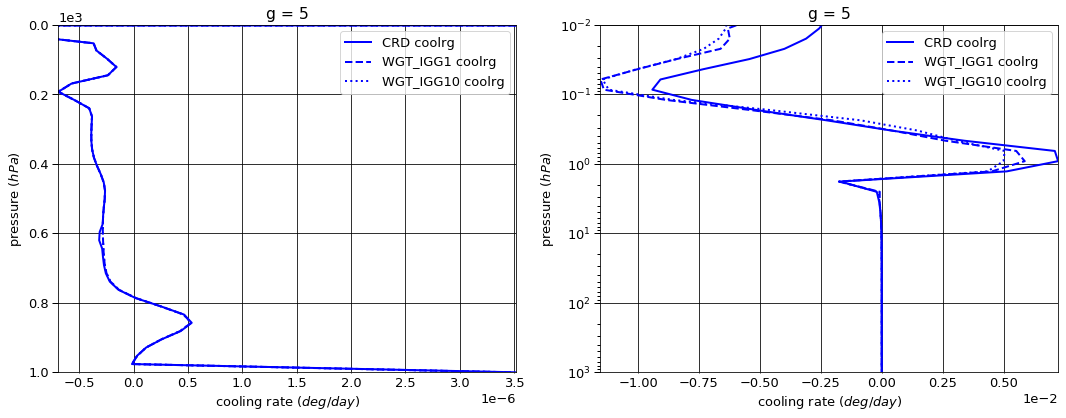

# Figure: cooling rate g-group 6

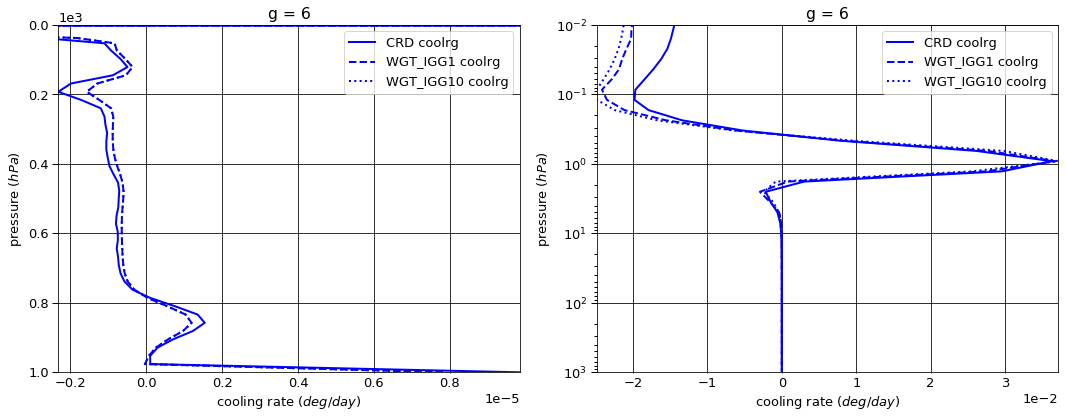

# Figure: cooling rate g-group 7

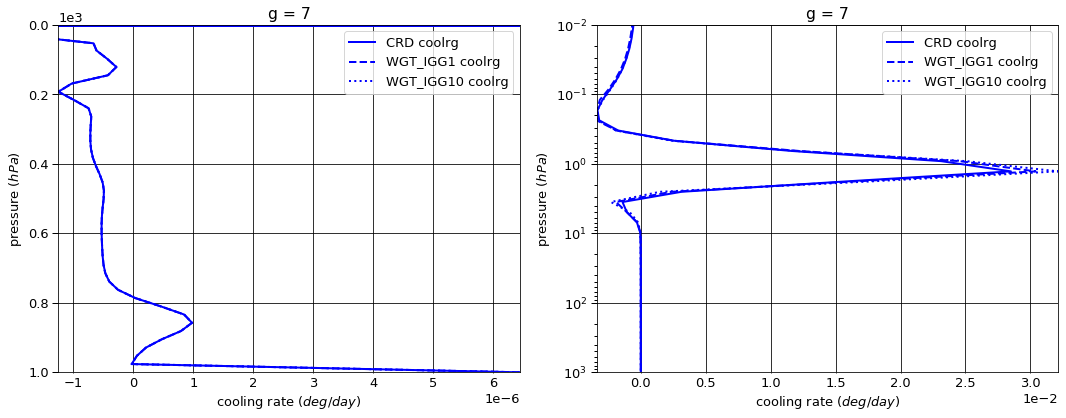

# Figure: cooling rate g-group 8

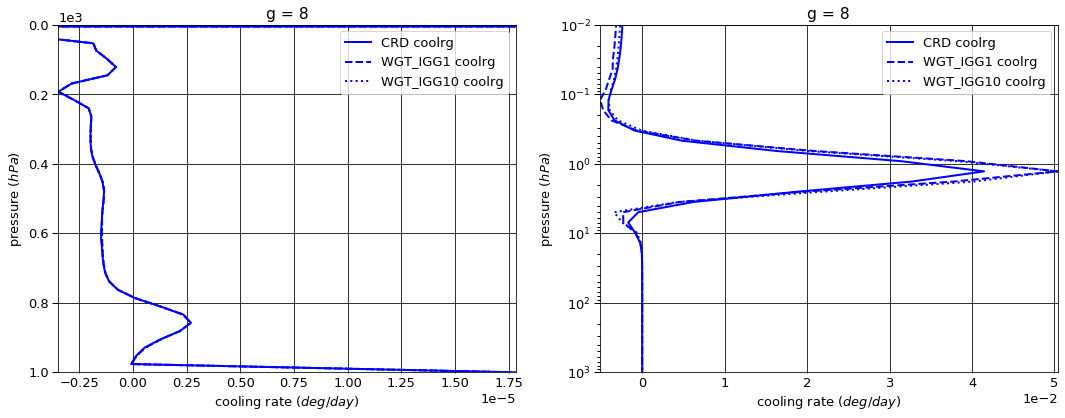

# Figure: cooling rate g-group 9

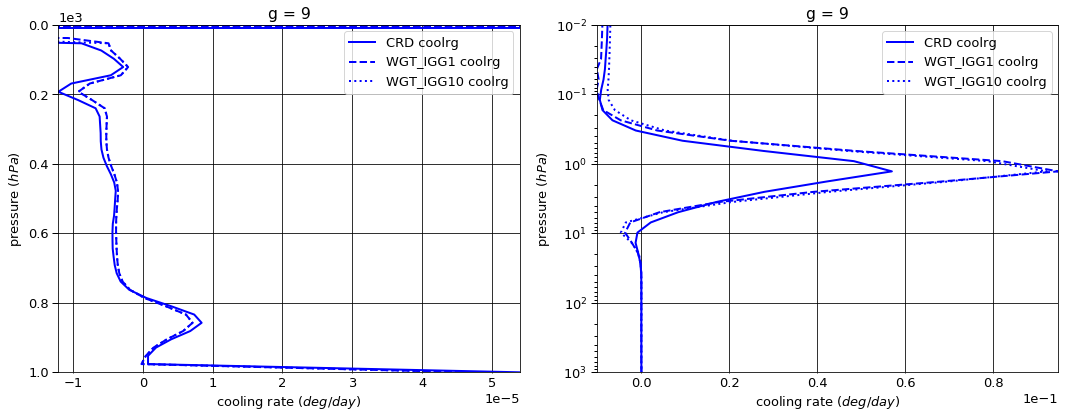

# Figure: cooling rate g-group 10

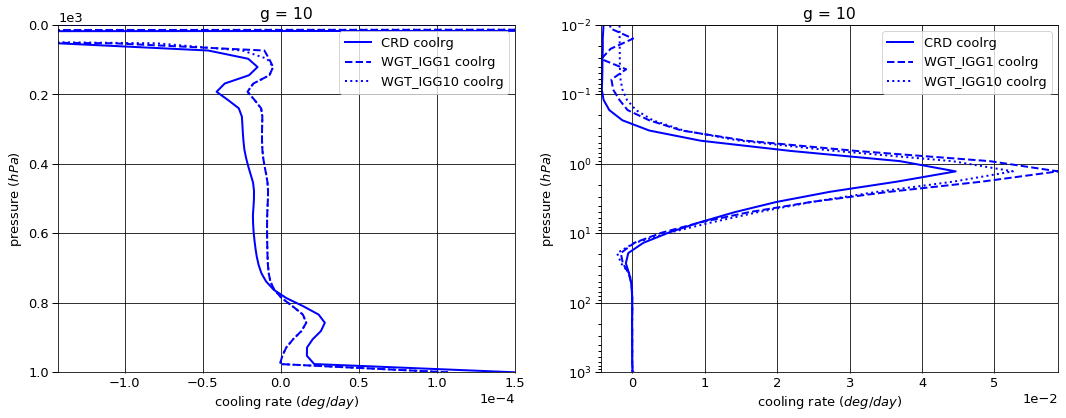

# Figure: cooling rate g-group 11

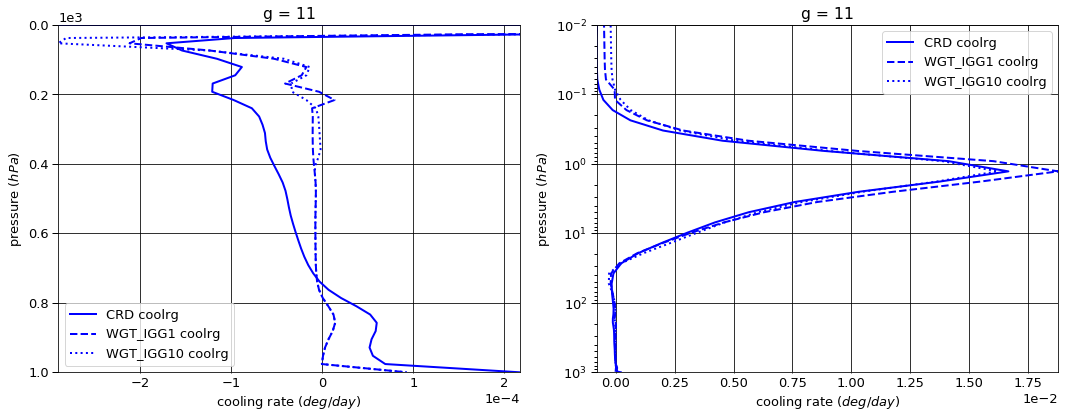

# Figure: cooling rate g-group 12

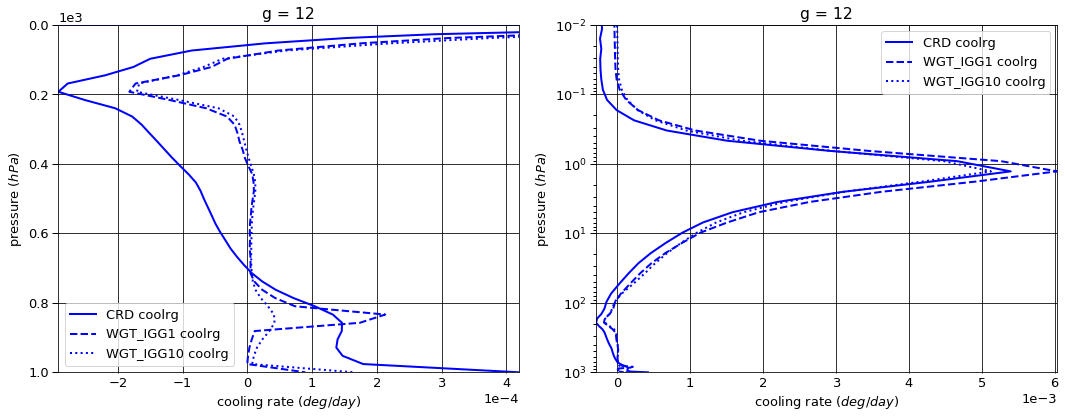

# Figure: cooling rate g-group 13

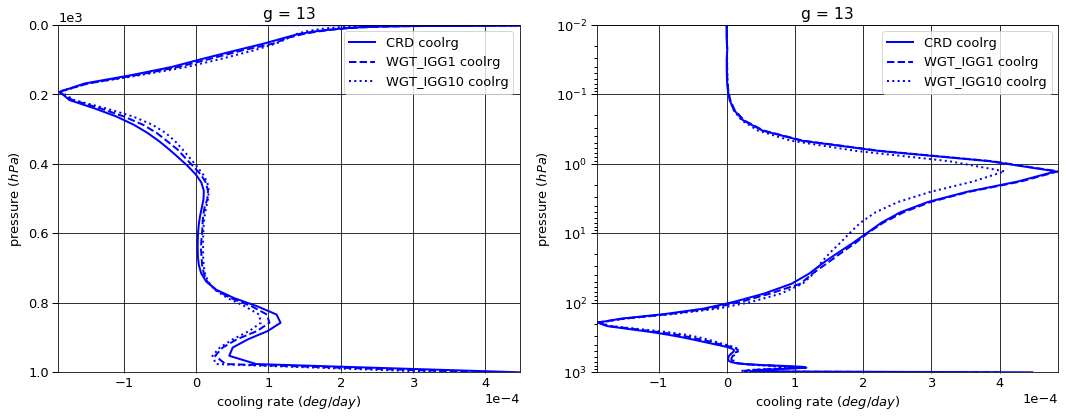

# Figure: cooling rate g-group 14

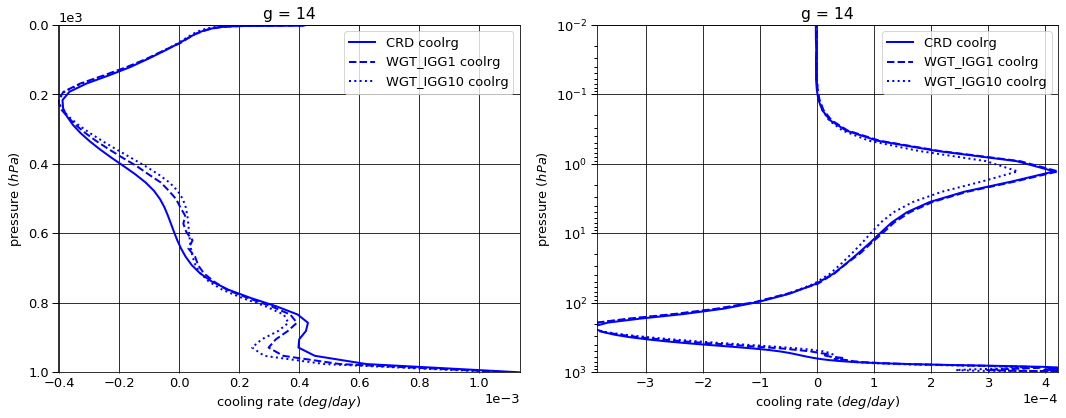

# Figure: cooling rate g-group 15

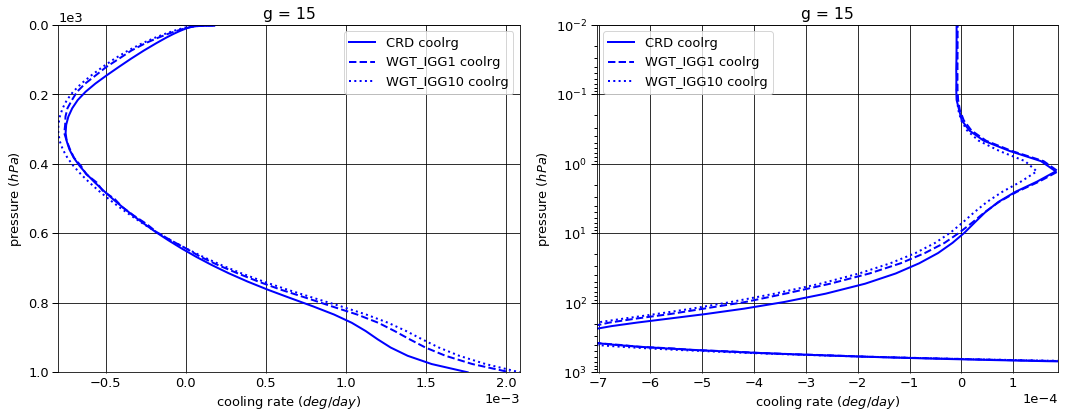

# Figure: cooling rate g-group 16

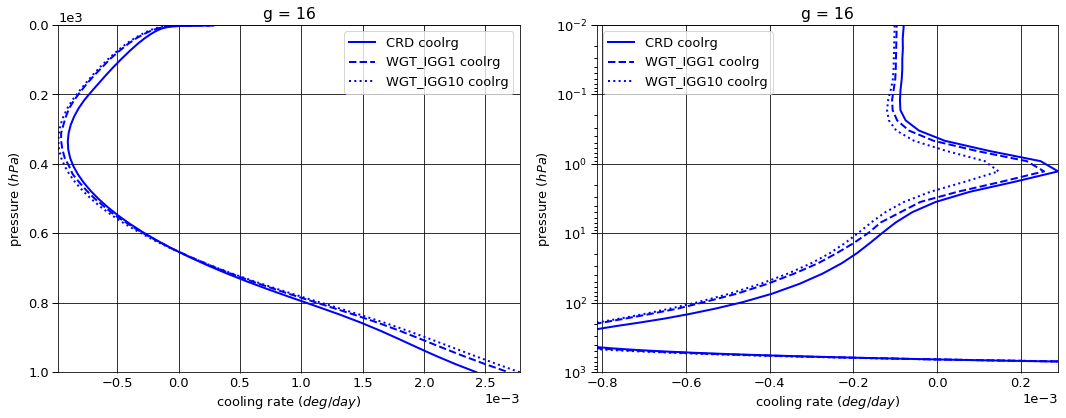

# Figure: cooling rate g-group 17

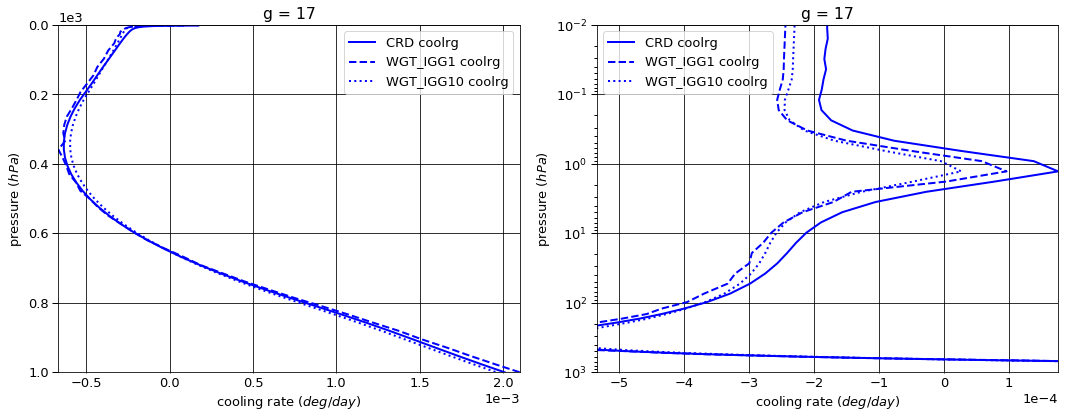

# Figure: cooling rate g-group 18

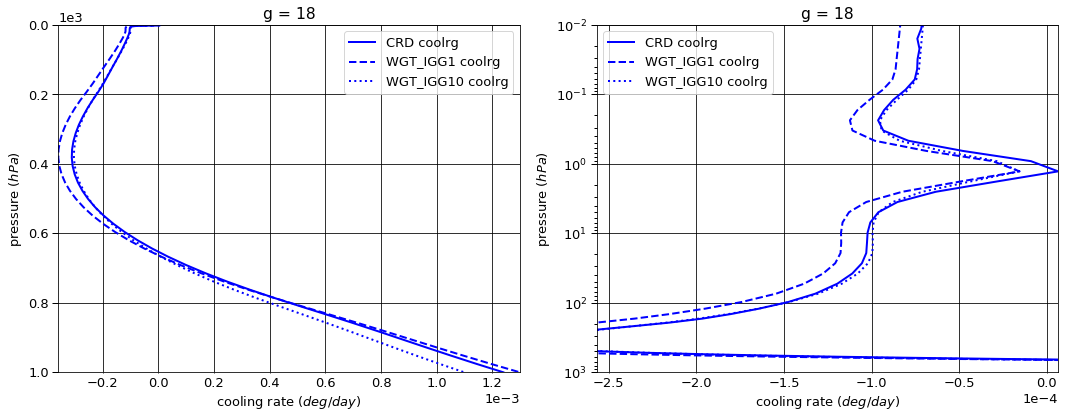

# Figure: cooling rate g-group total

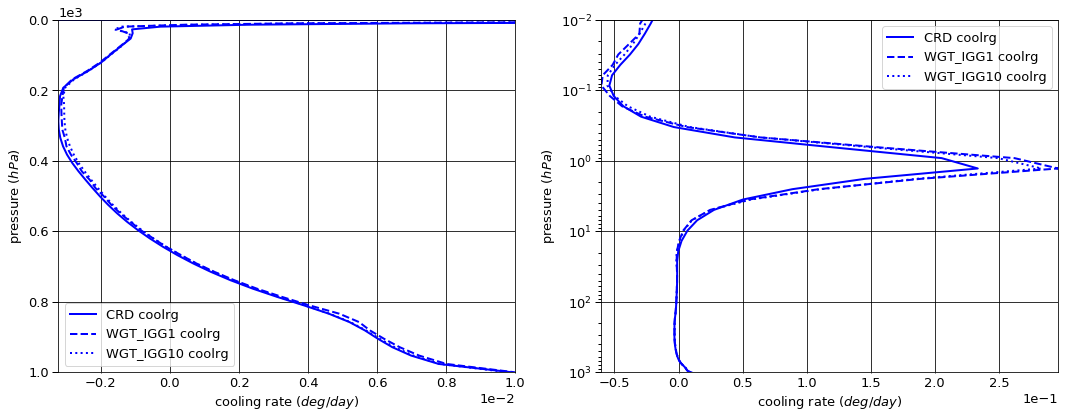

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000008  0.000000 -0.000008
   1013.0   76    -0.000793  0.000791 -0.000001
2  0.0      1     -0.000007  0.000000 -0.000007
   1013.0   76    -0.000678  0.000676 -0.000001
3  0.0      1     -0.000021  0.000000 -0.000021
   1013.0   76    -0.001575  0.001572 -0.000003
4  0.0      1     -0.000064  0.000000 -0.000064
   1013.0   76    -0.003215  0.003210 -0.000005
5  0.0      1     -0.000410  0.000000 -0.000410
   1013.0   76    -0.005753  0.005743 -0.000010
6  0.0      1     -0.002561  0.000000 -0.002561
   1013.0   76    -0.013012  0.012983 -0.000028
7  0.0      1     -0.003431  0.000000 -0.003431
   1013.0   76    -0.010604  0.010586 -0.000018
8  0.0      1     -0.007623  0.000000 -0.007623
   1013.0   76    -0.029187  0.029136 -0.000050
9  0.0      1     -0.013751  0.000000 -0.013751
   1013.0   76    -0.077313  0.077157 -0.000156
10 0.0      1     -0.018006  0.000000 -0.018006
   1013.0   76    -0.177329  0.176654 -0.000675
11 0.0      1     -0.009485  0.000000 -0.009485
   1013.0   76    -0.155206  0.152674 -0.002532
12 0.0      1     -0.008206  0.000000 -0.008206
   1013.0   76    -0.152182  0.143425 -0.008757
13 0.0      1     -0.003037  0.000000 -0.003037
   1013.0   76    -0.108366  0.106880 -0.001486
14 0.0      1     -0.010387  0.000000 -0.010387
   1013.0   76    -0.147241  0.139138 -0.008103
15 0.0      1     -0.051944  0.000000 -0.051944
   1013.0   76    -0.171650  0.120378 -0.051272
16 0.0      1     -0.224907  0.000000 -0.224907
   1013.0   76    -0.333998  0.115893 -0.218105
17 0.0      1     -0.629823  0.000000 -0.629823
   1013.0   76    -0.701426  0.080417 -0.621009
18 0.0      1     -4.500894  0.000000 -4.500894
   1013.0   76    -4.535925  0.044547 -4.491378


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000008  0.000000 -0.000008
   1013.0   76    -0.000793  0.000791 -0.000001
2  0.0      1     -0.000007  0.000000 -0.000007
   1013.0   76    -0.000678  0.000676 -0.000001
3  0.0      1     -0.000020  0.000000 -0.000020
   1013.0   76    -0.001575  0.001572 -0.000003
4  0.0      1     -0.000052  0.000000 -0.000052
   1013.0   76    -0.003215  0.003210 -0.000005
5  0.0      1     -0.000251  0.000000 -0.000251
   1013.0   76    -0.005753  0.005744 -0.000010
6  0.0      1     -0.002278  0.000000 -0.002278
   1013.0   76    -0.013012  0.012989 -0.000022
7  0.0      1     -0.003506  0.000000 -0.003506
   1013.0   76    -0.010604  0.010586 -0.000018
8  0.0      1     -0.008206  0.000000 -0.008206
   1013.0   76    -0.029187  0.029137 -0.000050
9  0.0      1     -0.017185  0.000000 -0.017185
   1013.0   76    -0.077313  0.077181 -0.000132
10 0.0      1     -0.020275  0.000000 -0.020275
   1013.0   76    -0.177329  0.177026 -0.000303
11 0.0      1     -0.009905  0.000000 -0.009905
   1013.0   76    -0.155206  0.154944 -0.000262
12 0.0      1     -0.005430  0.000000 -0.005430
   1013.0   76    -0.152182  0.151929 -0.000253
13 0.0      1     -0.002766  0.000000 -0.002766
   1013.0   76    -0.108366  0.107188 -0.001178
14 0.0      1     -0.007886  0.000000 -0.007886
   1013.0   76    -0.147241  0.141758 -0.005484
15 0.0      1     -0.044861  0.000000 -0.044861
   1013.0   76    -0.171650  0.132044 -0.039606
16 0.0      1     -0.219157  0.000000 -0.219157
   1013.0   76    -0.333998  0.122783 -0.211215
17 0.0      1     -0.628201  0.000000 -0.628201
   1013.0   76    -0.701426  0.082494 -0.618932
18 0.0      1     -4.497128  0.000000 -4.497128
   1013.0   76    -4.535925  0.045918 -4.490007


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000008  0.000000 -0.000008
   1013.0   76    -0.000793  0.000791 -0.000001
2  0.0      1     -0.000007  0.000000 -0.000007
   1013.0   76    -0.000678  0.000676 -0.000001
3  0.0      1     -0.000020  0.000000 -0.000020
   1013.0   76    -0.001575  0.001572 -0.000003
4  0.0      1     -0.000050  0.000000 -0.000050
   1013.0   76    -0.003215  0.003210 -0.000005
5  0.0      1     -0.000228  0.000000 -0.000228
   1013.0   76    -0.005753  0.005744 -0.000010
6  0.0      1     -0.002217  0.000000 -0.002217
   1013.0   76    -0.013012  0.012989 -0.000022
7  0.0      1     -0.003604  0.000000 -0.003604
   1013.0   76    -0.010604  0.010586 -0.000018
8  0.0      1     -0.008405  0.000000 -0.008405
   1013.0   76    -0.029187  0.029137 -0.000050
9  0.0      1     -0.017494  0.000000 -0.017494
   1013.0   76    -0.077313  0.077181 -0.000132
10 0.0      1     -0.019881  0.000000 -0.019881
   1013.0   76    -0.177329  0.177026 -0.000303
11 0.0      1     -0.009556  0.000000 -0.009556
   1013.0   76    -0.155206  0.154944 -0.000262
12 0.0      1     -0.005207  0.000000 -0.005207
   1013.0   76    -0.152182  0.151727 -0.000455
13 0.0      1     -0.002577  0.000000 -0.002577
   1013.0   76    -0.108366  0.107376 -0.000990
14 0.0      1     -0.006900  0.000000 -0.006900
   1013.0   76    -0.147241  0.142363 -0.004879
15 0.0      1     -0.041437  0.000000 -0.041437
   1013.0   76    -0.171650  0.135662 -0.035988
16 0.0      1     -0.221412  0.000000 -0.221412
   1013.0   76    -0.333998  0.120907 -0.213091
17 0.0      1     -0.635537  0.000000 -0.635537
   1013.0   76    -0.701426  0.074538 -0.626888
18 0.0      1     -4.503296  0.000000 -4.503296
   1013.0   76    -4.535925  0.038649 -4.497275


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      2.382810e-08  0.000000e+00  2.382810e-08
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1      1.099134e-07  0.000000e+00  1.099134e-07
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1      3.404120e-07  0.000000e+00  3.404120e-07
   1013.0   76    -2.168404e-19  0.000000e+00  0.000000e+00
4  0.0      1      1.280052e-05  0.000000e+00  1.280052e-05
   1013.0   76     4.336809e-19  0.000000e+00  0.000000e+00
5  0.0      1      1.598363e-04  0.000000e+00  1.598363e-04
   1013.0   76     0.000000e+00  1.388000e-07  1.387482e-07
6  0.0      1      2.825227e-04  0.000000e+00  2.825227e-04
   1013.0   76    -1.734723e-18  6.080000e-06  6.079904e-06
7  0.0      1     -7.510150e-05  0.000000e+00 -7.510150e-05
   1013.0   76     0.000000e+00  1.734723e-18  0.000000e+00
8  0.0      1     -5.827889e-04  0.000000e+00 -5.827889e-04
   1013.0   76     0.000000e+00  4.110000e-07  4.111340e-07
9  0.0      1     -3.433913e-03  0.000000e+00 -3.433913e-03
   1013.0   76     0.000000e+00  2.380800e-05  2.380782e-05
10 0.0      1     -2.268188e-03  0.000000e+00 -2.268188e-03
   1013.0   76     0.000000e+00  3.722900e-04  3.722918e-04
11 0.0      1     -4.201960e-04  0.000000e+00 -4.201960e-04
   1013.0   76     0.000000e+00  2.269970e-03  2.269973e-03
12 0.0      1      2.775560e-03  0.000000e+00  2.775560e-03
   1013.0   76     0.000000e+00  8.504730e-03  8.504728e-03
13 0.0      1      2.707456e-04  0.000000e+00  2.707456e-04
   1013.0   76     0.000000e+00  3.080000e-04  3.079999e-04
14 0.0      1      2.500838e-03  0.000000e+00  2.500838e-03
   1013.0   76     0.000000e+00  2.619390e-03  2.619395e-03
15 0.0      1      7.083030e-03  0.000000e+00  7.083030e-03
   1013.0   76     0.000000e+00  1.166582e-02  1.166582e-02
16 0.0      1      5.750010e-03  0.000000e+00  5.750010e-03
   1013.0   76     0.000000e+00  6.889770e-03  6.889770e-03
17 0.0      1      1.621590e-03  0.000000e+00  1.621590e-03
   1013.0   76     0.000000e+00  2.076684e-03  2.076680e-03
18 0.0      1      3.765600e-03  0.000000e+00  3.765600e-03
   1013.0   76    -8.881784e-16  1.371069e-03  1.371000e-03


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      3.481630e-08  0.000000e+00  3.481630e-08
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1      1.493597e-07  0.000000e+00  1.493597e-07
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1      4.174150e-07  0.000000e+00  4.174150e-07
   1013.0   76    -2.168404e-19  0.000000e+00  0.000000e+00
4  0.0      1      1.418588e-05  0.000000e+00  1.418588e-05
   1013.0   76     4.336809e-19  0.000000e+00  0.000000e+00
5  0.0      1      1.826947e-04  0.000000e+00  1.826947e-04
   1013.0   76     0.000000e+00  1.388000e-07  1.387482e-07
6  0.0      1      3.440603e-04  0.000000e+00  3.440603e-04
   1013.0   76    -1.734723e-18  6.080000e-06  6.079904e-06
7  0.0      1     -1.727588e-04  0.000000e+00 -1.727588e-04
   1013.0   76     0.000000e+00  1.734723e-18  0.000000e+00
8  0.0      1     -7.820801e-04  0.000000e+00 -7.820801e-04
   1013.0   76     0.000000e+00  4.110000e-07  4.111340e-07
9  0.0      1     -3.743122e-03  0.000000e+00 -3.743122e-03
   1013.0   76     0.000000e+00  2.380800e-05  2.380782e-05
10 0.0      1     -1.875040e-03  0.000000e+00 -1.875040e-03
   1013.0   76     0.000000e+00  3.722900e-04  3.722918e-04
11 0.0      1     -7.168580e-05  0.000000e+00 -7.168580e-05
   1013.0   76     0.000000e+00  2.269970e-03  2.269973e-03
12 0.0      1      2.998293e-03  0.000000e+00  2.998293e-03
   1013.0   76     0.000000e+00  8.302500e-03  8.302499e-03
13 0.0      1      4.597581e-04  0.000000e+00  4.597581e-04
   1013.0   76     0.000000e+00  4.956600e-04  4.956528e-04
14 0.0      1      3.487398e-03  0.000000e+00  3.487398e-03
   1013.0   76     0.000000e+00  3.224100e-03  3.224100e-03
15 0.0      1      1.050711e-02  0.000000e+00  1.050711e-02
   1013.0   76     0.000000e+00  1.528367e-02  1.528367e-02
16 0.0      1      3.495150e-03  0.000000e+00  3.495150e-03
   1013.0   76     0.000000e+00  5.013290e-03  5.013290e-03
17 0.0      1     -5.714630e-03  0.000000e+00 -5.714630e-03
   1013.0   76     0.000000e+00 -5.879333e-03 -5.879340e-03
18 0.0      1     -2.402000e-03  0.000000e+00 -2.402000e-03
   1013.0   76    -8.881784e-16 -5.897453e-03 -5.897500e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      9.817722e-02
   1001.112500 75     4.821853e-07
2  0.000312    1      4.030380e-02
   1001.112500 75     4.114236e-07
3  0.000312    1      1.416390e-02
   1001.112500 75     9.550588e-07
4  0.000312    1      8.413620e-03
   1001.112500 75     1.935660e-06
5  0.000312    1     -3.286327e-03
   1001.112500 75     3.519074e-06
6  0.000312    1     -1.378589e-02
   1001.112500 75     9.843407e-06
7  0.000312    1     -2.793054e-04
   1001.112500 75     6.444126e-06
8  0.000312    1     -2.107888e-03
   1001.112500 75     1.782236e-05
9  0.000312    1     -7.048077e-03
   1001.112500 75     5.400200e-05
10 0.000312    1     -3.887397e-03
   1001.112500 75     1.501753e-04
11 0.000312    1     -8.196441e-04
   1001.112500 75     2.170431e-04
12 0.000312    1     -2.458450e-04
   1001.112500 75     4.200521e-04
13 0.000312    1     -6.339474e-07
   1001.112500 75     4.481226e-04
14 0.000312    1     -2.074697e-06
   1001.112500 75     1.135783e-03
15 0.000312    1     -8.606688e-06
   1001.112500 75     1.759701e-03
16 0.000312    1     -7.737954e-05
   1001.112500 75     2.428601e-03
17 0.000312    1     -1.739556e-04
   1001.112500 75     2.010201e-03
18 0.000312    1     -6.831012e-05
   1001.112500 75     1.239546e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      1.031425e-01
   1001.112500 75     4.821853e-07
2  0.000312    1      4.320419e-02
   1001.112500 75     4.114236e-07
3  0.000312    1      1.432661e-02
   1001.112500 75     9.550588e-07
4  0.000312    1      8.376445e-03
   1001.112500 75     1.935660e-06
5  0.000312    1     -7.091065e-03
   1001.112500 75     3.471028e-06
6  0.000312    1     -1.934449e-02
   1001.112500 75     7.856306e-06
7  0.000312    1     -3.650250e-04
   1001.112500 75     6.444126e-06
8  0.000312    1     -2.838692e-03
   1001.112500 75     1.768186e-05
9  0.000312    1     -8.380905e-03
   1001.112500 75     4.677736e-05
10 0.000312    1     -3.121398e-03
   1001.112500 75     1.071373e-04
11 0.000312    1     -5.494441e-04
   1001.112500 75     9.270153e-05
12 0.000312    1     -5.946317e-05
   1001.112500 75     8.938499e-05
13 0.000312    1     -1.834654e-07
   1001.112500 75     3.996774e-04
14 0.000312    1     -9.173022e-07
   1001.112500 75     1.101990e-03
15 0.000312    1     -6.902613e-06
   1001.112500 75     2.024465e-03
16 0.000312    1     -9.263754e-05
   1001.112500 75     2.690450e-03
17 0.000312    1     -2.383835e-04
   1001.112500 75     2.101092e-03
18 0.000312    1     -7.885364e-05
   1001.112500 75     1.298663e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      1.045579e-01
   1001.112500 75     4.821853e-07
2  0.000312    1      4.322750e-02
   1001.112500 75     4.114236e-07
3  0.000312    1      1.209121e-02
   1001.112500 75     9.550588e-07
4  0.000312    1      6.649651e-03
   1001.112500 75     1.935660e-06
5  0.000312    1     -7.997820e-03
   1001.112500 75     3.471028e-06
6  0.000312    1     -2.046155e-02
   1001.112500 75     7.856306e-06
7  0.000312    1     -3.380513e-04
   1001.112500 75     6.444126e-06
8  0.000312    1     -2.406898e-03
   1001.112500 75     1.768186e-05
9  0.000312    1     -6.683641e-03
   1001.112500 75     4.677736e-05
10 0.000312    1     -1.864226e-03
   1001.112500 75     1.071373e-04
11 0.000312    1     -2.645228e-04
   1001.112500 75     9.270153e-05
12 0.000312    1     -1.933574e-05
   1001.112500 75     1.646299e-04
13 0.000312    1     -2.538556e-08
   1001.112500 75     3.462299e-04
14 0.000312    1     -8.311836e-07
   1001.112500 75     1.077023e-03
15 0.000312    1     -7.441591e-06
   1001.112500 75     2.085417e-03
16 0.000312    1     -9.676470e-05
   1001.112500 75     2.780576e-03
17 0.000312    1     -2.241911e-04
   1001.112500 75     1.960695e-03
18 0.000312    1     -6.661439e-05
   1001.112500 75     1.098953e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.965280e-03
   1001.112500 75     0.000000e+00
2  0.000312    1      2.900389e-03
   1001.112500 75    -5.293956e-23
3  0.000312    1      1.627110e-04
   1001.112500 75     0.000000e+00
4  0.000312    1     -3.717540e-05
   1001.112500 75     0.000000e+00
5  0.000312    1     -3.804738e-03
   1001.112500 75    -4.804590e-08
6  0.000312    1     -5.558596e-03
   1001.112500 75    -1.987101e-06
7  0.000312    1     -8.571964e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -7.308037e-04
   1001.112500 75    -1.405000e-07
9  0.000312    1     -1.332828e-03
   1001.112500 75    -7.224646e-06
10 0.000312    1      7.659982e-04
   1001.112500 75    -4.303803e-05
11 0.000312    1      2.702000e-04
   1001.112500 75    -1.243415e-04
12 0.000312    1      1.863818e-04
   1001.112500 75    -3.306671e-04
13 0.000312    1      4.504821e-07
   1001.112500 75    -4.844526e-05
14 0.000312    1      1.157395e-06
   1001.112500 75    -3.379310e-05
15 0.000312    1      1.704075e-06
   1001.112500 75     2.647648e-04
16 0.000312    1     -1.525800e-05
   1001.112500 75     2.618487e-04
17 0.000312    1     -6.442794e-05
   1001.112500 75     9.089050e-05
18 0.000312    1     -1.054352e-05
   1001.112500 75     5.911720e-05


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      6.380730e-03
   1001.112500 75     0.000000e+00
2  0.000312    1      2.923699e-03
   1001.112500 75    -5.293956e-23
3  0.000312    1     -2.072690e-03
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.763970e-03
   1001.112500 75     0.000000e+00
5  0.000312    1     -4.711493e-03
   1001.112500 75    -4.804590e-08
6  0.000312    1     -6.675658e-03
   1001.112500 75    -1.987101e-06
7  0.000312    1     -5.874592e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -2.990103e-04
   1001.112500 75    -1.405000e-07
9  0.000312    1      3.644359e-04
   1001.112500 75    -7.224646e-06
10 0.000312    1      2.023171e-03
   1001.112500 75    -4.303803e-05
11 0.000312    1      5.551213e-04
   1001.112500 75    -1.243415e-04
12 0.000312    1      2.265092e-04
   1001.112500 75    -2.554222e-04
13 0.000312    1      6.085619e-07
   1001.112500 75    -1.018928e-04
14 0.000312    1      1.243513e-06
   1001.112500 75    -5.875950e-05
15 0.000312    1      1.165097e-06
   1001.112500 75     3.257163e-04
16 0.000312    1     -1.938517e-05
   1001.112500 75     3.519752e-04
17 0.000312    1     -5.023554e-05
   1001.112500 75    -4.950620e-05
18 0.000312    1      1.695731e-06
   1001.112500 75    -1.405929e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.484565,0.000000,-5.484565
1013.0,76,-6.625452,1.221862,-5.403591



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.467122,0.00000,-5.467122
1013.0,76,-6.625452,1.25797,-5.367483



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.477837,0.000000,-5.477837
1013.0,76,-6.625452,1.245077,-5.380376



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.744282e-02,0.000000,0.017443
1013.0,76,-8.881784e-16,0.036108,0.036108



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,6.727933e-03,0.000000,0.006728
1013.0,76,-8.881784e-16,0.023215,0.023215


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.129267
1001.112500,75,0.009905



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.126881
1001.112500,75,0.009992



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.126094
1001.112500,75,0.009799



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.002386
1001.112500,75,0.000087



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003173
1001.112500,75,-0.000105


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000145,0.000100
2,0.000123,0.000086
3,0.000282,0.000199
4,0.000541,0.000414
5,0.000986,0.000737
6,0.002245,0.001664
7,0.001932,0.001337
8,0.005182,0.003705
9,0.013582,0.009843


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.023869e-16
2,4.670020e-17
3,1.077593e-17
4,2.486516e-18
5,5.737563e-19
6,1.323926e-19
7,6.074306e-19
8,1.402453e-19
9,3.238025e-20


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.023869e-16,NaN,0.000145,0.000100,0.000145,0.000100,1.0
2,4.670020e-17,2.307471e-01,0.000123,0.000086,0.000268,0.000185,1.0
3,1.077593e-17,2.307471e-01,0.000282,0.000199,0.000550,0.000385,1.0
4,2.486516e-18,2.307471e-01,0.000541,0.000414,0.001091,0.000799,1.0
5,5.737563e-19,2.307471e-01,0.000986,0.000737,0.002077,0.001536,1.0
6,1.323926e-19,2.307471e-01,0.002245,0.001664,0.004323,0.003200,1.0
7,6.074306e-19,4.588100e+00,0.001932,0.001337,0.006255,0.004537,20.0
8,1.402453e-19,2.308829e-01,0.005182,0.003705,0.011436,0.008242,20.0
9,3.238025e-20,2.308829e-01,0.013582,0.009843,0.025018,0.018085,20.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog          ratio        taulyr
layer g  pressure                                                            
1     1  0.000312     5.552039e-16  4.053246e-16       1.369776  2.938960e+00
      2  0.000312     8.108185e-17  6.493102e-17       1.248738  4.292051e-01
      3  0.000312     9.269738e-18  8.379126e-18       1.106289  4.906916e-02
      4  0.000312     3.227234e-18  2.411563e-18       1.338234  1.708330e-02
      5  0.000312     6.256813e-19  4.003278e-19       1.562923  3.312030e-03
      6  0.000312     8.853877e-20  6.070846e-20       1.458426  4.686781e-04
      7  0.000312     8.396756e-22  8.263755e-22       1.016094  4.444805e-06
      8  0.000312     2.595733e-21  2.291009e-21       1.133008  1.374045e-05
      9  0.000312     3.539753e-21  2.130841e-21       1.661199  1.873761e-05
      10 0.000312     9.701072e-22  4.383202e-22       2.213238  5.135242e-06
      11 0.000312     3.645704e-22  1.634160e-22       2.230935  1.929846e-06
      12 0.000312     1.074796e-22  4.561227e-23       2.356375  5.689411e-07
      13 0.000312     2.188015e-24  2.146215e-24       1.019476  1.158221e-08
      14 0.000312     2.182168e-24  1.972437e-24       1.106331  1.155126e-08
      15 0.000312     1.731479e-24  1.136184e-24       1.523942  9.165547e-09
      16 0.000312     3.880783e-24  8.961828e-25       4.330348  2.054284e-08
      17 0.000312     3.093928e-24  3.223688e-25       9.597481  1.637764e-08
      18 0.000312     1.287550e-25  4.397084e-31  292819.200000  6.815621e-10
2     1  0.000750     5.548530e-16  4.054358e-16       1.368535  1.183026e+00
      2  0.000750     8.122829e-17  6.507609e-17       1.248205  1.731903e-01
      3  0.000750     9.310149e-18  8.415896e-18       1.106258  1.985057e-02
      4  0.000750     3.235406e-18  2.420633e-18       1.336595  6.898346e-03
      5  0.000750     6.269897e-19  4.015858e-19       1.561284  1.336831e-03
      6  0.000750     8.890393e-20  6.102579e-20       1.456825  1.895558e-04
      7  0.000750     8.729076e-22  8.592245e-22       1.015925  1.861164e-06
      8  0.000750     2.615029e-21  2.308019e-21       1.133019  5.575615e-06
      9  0.000750     3.557554e-21  2.140947e-21       1.661673  7.585212e-06
      10 0.000750     9.718948e-22  4.395880e-22       2.210922  2.072218e-06
      11 0.000750     3.649682e-22  1.637849e-22       2.228338  7.781643e-07
      12 0.000750     1.076251e-22  4.573039e-23       2.353470  2.294720e-07
      13 0.000750     2.207891e-24  2.165699e-24       1.019482  4.707539e-09
      14 0.000750     2.198809e-24  1.987261e-24       1.106452  4.688174e-09
      15 0.000750     1.742452e-24  1.142285e-24       1.525408  3.715156e-09
      16 0.000750     3.894396e-24  8.992706e-25       4.330616  8.303408e-09
      17 0.000750     3.100422e-24  3.230834e-25       9.596350  6.610542e-09
      18 0.000750     1.292411e-25  5.410699e-31  238862.090000  2.755604e-10
3     1  0.001052     5.541197e-16  4.056714e-16       1.365932  1.656866e+00
      2  0.001052     8.153675e-17  6.538229e-17       1.247077  2.438019e-01
      3  0.001052     9.395024e-18  8.493124e-18       1.106192  2.809193e-02
      4  0.001052     3.252581e-18  2.439431e-18       1.333336  9.725499e-03
      5  0.001052     6.295803e-19  4.039615e-19       1.558516  1.882500e-03
      6  0.001052     8.962415e-20  6.161175e-20       1.454660  2.679840e-04
      7  0.001052     9.046834e-22  8.905747e-22       1.015842  2.705081e-06
      8  0.001052     2.647539e-21  2.335852e-21       1.133436  7.916369e-06
      9  0.001052     3.593866e-21  2.160624e-21       1.663346  1.074597e-05
      10 0.001052     9.753488e-22  4.418648e-22       2.207346  2.916377e-06
      11 0.001052     3.657482e-22  1.644811e-22       2.223649  1.093619e-06
      12 0.001052     1.079241e-22  4.596422e-23       2.348002  3.227023e-07
      13 0.001052     2.245043e-24  2.202012e-24       1.019542  6.712874e-09
      14 0.001052     2.232301e-24  2.016851e-24 

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
